In [1]:
def IntialiseEnv():
    nb_dir = os.path.split(os.getcwd())[0]
    if nb_dir not in sys.path:
        sys.path.append(nb_dir)
    invalid_path='/opt/ros/kinetic/lib/python2.7/dist-packages'
    if invalid_path in sys.path:
        sys.path.remove(invalid_path)

In [2]:
## Import libraries need to be imported, Dont forget to update requirements.txt!
import os
import sys
IntialiseEnv()
import numpy as np
import cv2
import skimage.color
import skimage.filters
import skimage.io
import matplotlib.pyplot as plt
import import_ipynb
import random
from PIL import Image

In [3]:
## Read image in path
def readImage(path):
    return cv2.imread(path)

In [53]:
def loadSampleImg(path):
    img=readImage(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(80,80))
    return img

In [54]:
## Sharpen Image
def sharpen(img):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    im = cv2.filter2D(img, -1, kernel)
    plt.imshow(im)
    return im

In [55]:
# Excessive sharpening image
def excessive(img):
    kernel = np.array([[1,1,1], [1,-7,1], [1,1,1]])
    im = cv2.filter2D(img, -1, kernel)
    return im

In [56]:
# Blur of images
def blur(img):
    blur =  cv2.medianBlur(img,5)
    return blur

In [57]:
# Edge Enhancement
def edgeEnhancement(img):
    kernel = np.array([[-1,-1,-1,-1,-1],
                               [-1,2,2,2,-1],
                               [-1,2,8,2,-1],
                               [-2,2,2,2,-1],
                               [-1,-1,-1,-1,-1]])/8.0
    img = cv2.filter2D(img, -1, kernel)
    image=cv2.filter2D(img, -1, kernel)
    return image

In [58]:
# Weight image with another image
def addWeightedImg(img,blur):
    result = cv2.addWeighted(img, 1, blur, -0.5, 0)
    return result

In [59]:
# Contrast Enhancement
def ContrastEnhancement():
    hsvImg = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsvImg[...,1] = hsvImg[...,1]*1.6
    hsvImg[...,2] = hsvImg[...,2]*0.8
    img=cv2.cvtColor(hsvImg,cv2.COLOR_HSV2RGB)

In [60]:
#Edge Detection
def CannyEdgeDetection(img):
    edged=cv2.Canny(img,60,150)

In [61]:
# Find Contours
def FindContours(edged):
    contours, hierarchy=cv2.findContours(edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img,contours,-1,(0,255,0),1)
    ret =40
    img[img>ret]=255
    img[img<=ret]=0
    img =cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

In [62]:
def Convert2Grayscale(img):
    return skimage.color.rgb2gray(img)

In [63]:
def ThresholdSegmentationOtsu(img):
    t = skimage.filters.threshold_otsu(img)
    mask = img > t
    return mask

In [64]:
def RemoveNoiseColouredImg(img):
    dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

In [65]:
def HistogramEqualization(img):
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    return cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB)

In [66]:
def CalculateContrast(img):
    # convert to LAB color space
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2LAB)

    # separate channels
    L,A,B=cv2.split(lab)

    # compute minimum and maximum in 5x5 region using erode and dilate
    kernel = np.ones((5,5),np.uint8)
    min = cv2.erode(L,kernel,iterations = 1)
    max = cv2.dilate(L,kernel,iterations = 1)

    # convert min and max to floats
    min = min.astype(np.float64) 
    max = max.astype(np.float64) 

    # compute local contrast
    contrast = (max-min)/(max+min)

    # get average across whole image
    average_contrast = 100*np.mean(contrast)

    print(str(average_contrast)+"%")

In [67]:
def from_pil(pimg):
    pimg = pimg.convert(mode='RGB')
    nimg = np.asarray(pimg)
    nimg.flags.writeable = True
    return nimg

def to_pil(nimg):
    return Image.fromarray(np.uint8(nimg))

def stretch_pre(nimg):
    """
    from 'Applicability Of White-Balancing Algorithms to Restoring Faded Colour Slides: An Empirical Evaluation'
    """
    nimg = nimg.transpose(2, 0, 1)
    nimg[0] = np.maximum(nimg[0]-nimg[0].min(),0)
    nimg[1] = np.maximum(nimg[1]-nimg[1].min(),0)
    nimg[2] = np.maximum(nimg[2]-nimg[2].min(),0)
    return nimg.transpose(1, 2, 0)

def grey_world(nimg):
    nimg = nimg.transpose(2, 0, 1).astype(np.uint32)
    mu_g = np.average(nimg[1])
    nimg[0] = np.minimum(nimg[0]*(mu_g/np.average(nimg[0])),255)
    nimg[2] = np.minimum(nimg[2]*(mu_g/np.average(nimg[2])),255)
    return  nimg.transpose(1, 2, 0).astype(np.uint8)

def max_white(nimg):
    if nimg.dtype==np.uint8:
        brightest=float(2**8)
    elif nimg.dtype==np.uint16:
        brightest=float(2**16)
    elif nimg.dtype==np.uint32:
        brightest=float(2**32)
    else:
        brightest==float(2**8)
    nimg = nimg.transpose(2, 0, 1)
    nimg = nimg.astype(np.int32)
    nimg[0] = np.minimum(nimg[0] * (brightest/float(nimg[0].max())),255)
    nimg[1] = np.minimum(nimg[1] * (brightest/float(nimg[1].max())),255)
    nimg[2] = np.minimum(nimg[2] * (brightest/float(nimg[2].max())),255)
    return nimg.transpose(1, 2, 0).astype(np.uint8)

def stretch(nimg):
    return max_white(stretch_pre(nimg))

def retinex(nimg):
    nimg = nimg.transpose(2, 0, 1).astype(np.uint32)
    mu_g = nimg[1].max()
    nimg[0] = np.minimum(nimg[0]*(mu_g/float(nimg[0].max())),255)
    nimg[2] = np.minimum(nimg[2]*(mu_g/float(nimg[2].max())),255)
    return nimg.transpose(1, 2, 0).astype(np.uint8)

def retinex_adjust(nimg):
    """
    from 'Combining Gray World and Retinex Theory for Automatic White Balance in Digital Photography'
    """
    nimg = nimg.transpose(2, 0, 1).astype(np.uint32)
    sum_r = np.sum(nimg[0])
    sum_r2 = np.sum(nimg[0]**2)
    max_r = nimg[0].max()
    max_r2 = max_r**2
    sum_g = np.sum(nimg[1])
    max_g = nimg[1].max()
    coefficient = np.linalg.solve(np.array([[sum_r2,sum_r],[max_r2,max_r]]),
                                  np.array([sum_g,max_g]))
    nimg[0] = np.minimum((nimg[0]**2)*coefficient[0] + nimg[0]*coefficient[1],255)
    sum_b = np.sum(nimg[1])
    sum_b2 = np.sum(nimg[1]**2)
    max_b = nimg[1].max()
    max_b2 = max_r**2
    coefficient = np.linalg.solve(np.array([[sum_b2,sum_b],[max_b2,max_b]]),
                                             np.array([sum_g,max_g]))
    nimg[1] = np.minimum((nimg[1]**2)*coefficient[0] + nimg[1]*coefficient[1],255)
    return nimg.transpose(1, 2, 0).astype(np.uint8)

def retinex_with_adjust(nimg):
    return retinex_adjust(retinex(nimg))

def standard_deviation_weighted_grey_world(nimg,subwidth,subheight):
    """
    This function does not work correctly
    """
    nimg = nimg.astype(np.uint32)
    height, width,ch = nimg.shape
    strides = nimg.itemsize*np.array([width*subheight,subwidth,width,3,1])
    shape = (height/subheight, width/subwidth, subheight, subwidth,3)
    blocks = np.lib.stride_tricks.as_strided(nimg, shape=shape, strides=strides)
    y,x = blocks.shape[:2]
    std_r = np.zeros([y,x],dtype=np.float16)
    std_g = np.zeros([y,x],dtype=np.float16)
    std_b = np.zeros([y,x],dtype=np.float16)
    std_r_sum = 0.0
    std_g_sum = 0.0
    std_b_sum = 0.0
    for i in xrange(y):
        for j in xrange(x):
            subblock = blocks[i,j]
            subb = subblock.transpose(2, 0, 1)
            std_r[i,j]=np.std(subb[0])
            std_g[i,j]=np.std(subb[1])
            std_b[i,j]=np.std(subb[2])
            std_r_sum += std_r[i,j]
            std_g_sum += std_g[i,j]
            std_b_sum += std_b[i,j]
    sdwa_r = 0.0
    sdwa_g = 0.0
    sdwa_b = 0.0
    for i in xrange(y):
        for j in xrange(x):
            subblock = blocks[i,j]
            subb = subblock.transpose(2, 0, 1)
            mean_r=np.mean(subb[0])
            mean_g=np.mean(subb[1])
            mean_b=np.mean(subb[2])
            sdwa_r += (std_r[i,j]/std_r_sum)*mean_r
            sdwa_g += (std_g[i,j]/std_g_sum)*mean_g
            sdwa_b += (std_b[i,j]/std_b_sum)*mean_b
    sdwa_avg = (sdwa_r+sdwa_g+sdwa_b)/3
    gain_r = sdwa_avg/sdwa_r
    gain_g = sdwa_avg/sdwa_g
    gain_b = sdwa_avg/sdwa_b
    nimg = nimg.transpose(2, 0, 1)
    nimg[0] = np.minimum(nimg[0]*gain_r,255)
    nimg[1] = np.minimum(nimg[1]*gain_g,255)
    nimg[2] = np.minimum(nimg[2]*gain_b,255)
    return nimg.transpose(1, 2, 0).astype(np.uint8)


In [4]:
# Final Feature Extraction Algo
# See if there any room for improvements
# See if colour consistency make any changes for real
def FeatureExtraction(img):
    pil_image=to_pil(retinex((img)))
    open_cv_image = np.array(pil_image) 
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    hist_equalization_result = HistogramEqualization(open_cv_image)
    edgeEnhanced=edgeEnhancement(hist_equalization_result)
    gray= Convert2Grayscale(edgeEnhanced)
    return gray

In [44]:
def ProposedSegmentationAlgoWithDisplay(path): 
    img=loadSampleImg(path)
    pil_image=to_pil(retinex((img)))
    open_cv_image = np.array(pil_image) 
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    hist_equalization_result = HistogramEqualization(open_cv_image)
    edgeEnhanced=edgeEnhancement(hist_equalization_result)
    gray= Convert2Grayscale(edgeEnhanced)
    fig, ax = plt.subplots(nrows=1, ncols=4)
    ax[0].imshow(img)
    ax[1].imshow(hist_equalization_result)
    ax[2].imshow(edgeEnhanced)
    ax[3].imshow(gray)
    plt.show() 

In [ ]:
def rBrightness(image,ratio):
    hsv=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    brightness=np.float64(hsv[:, :, 2])
    brightness=brightness*(1.0+np.random.uniform(-ratio,ratio))
    brightness[brightness>255]=255
    brightness[brightness<0]=0
    hsv[:, :, 2]=brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
def rRotation(image, angle):
    if angle==0:
        return image
    angle=np.random.uniform(-angle,angle)
    rows,cols=image.shape[:2]
    size=rows,cols
    center=rows/2,cols/2
    scale=1.0
    rotation=cv2.getRotationMatrix2D(center,angle,scale)
    return cv2.warpAffine(image,rotation,size)
def rTranslation(image, translation):
    if translation==0:
        return 0
    rows,cols=image.shape[:2]
    size=rows,cols
    x=np.random.uniform(-translation,translation)
    y=np.random.uniform(-translation,translation)
    trans=np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image,trans,size)
def rShear(image, shear):
    if shear==0:
        return image
    rows,cols=image.shape[:2]
    size=rows,cols
    left,right,top,bottom=shear,cols-shear,shear,rows-shear
    dx=np.random.uniform(-shear,shear)
    dy=np.random.uniform(-shear,shear)
    p1=np.float32([[left,top],[right,top],[left,bottom]])
    p2=np.float32([[left+dx,top],[right+dx,top+dy],[left,bottom+dy]])
    move=cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image,move,size)
def agument_image(image,brightness,angle,translation,shear):
    image=rBrightness(image,brightness)
    image=rRotation(image,angle)
    image=rTranslation(image,translation)
    image=rShear(image,shear)
    return image

In [69]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00000/00000_00024.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00000/00000_00000.ppm')

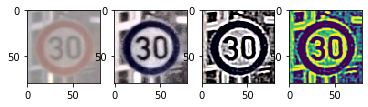

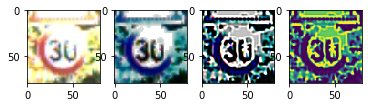

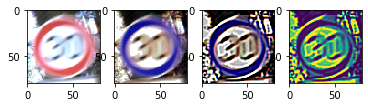

In [291]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00001/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00001/00001_00008.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00001/00042_00029.ppm')

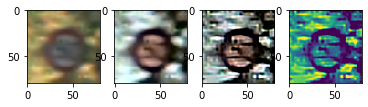

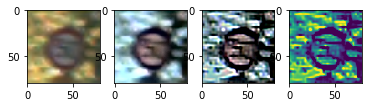

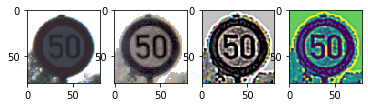

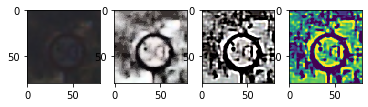

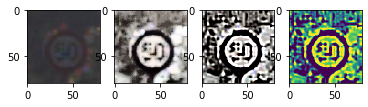

In [292]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00002/00002_00002.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00002/00002_00003.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00002/00001_00026.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00002/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00002/00001_00005.ppm')

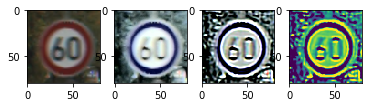

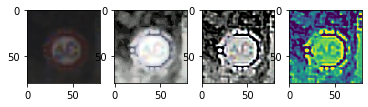

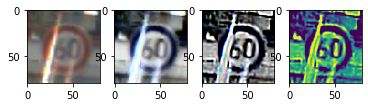

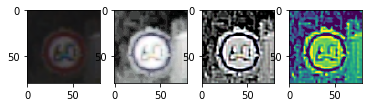

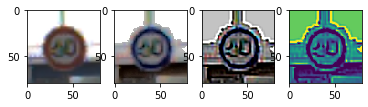

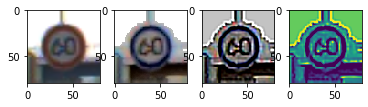

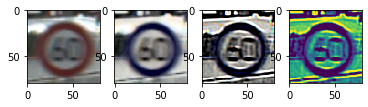

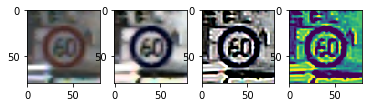

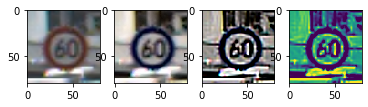

In [293]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00004_00022.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00001_00016.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00000_00006.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00002_00002.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00002_00003.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00001_00026.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00003/00001_00005.ppm')

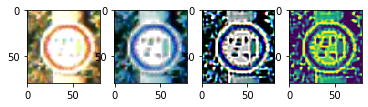

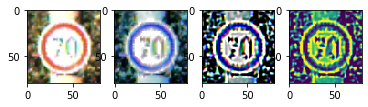

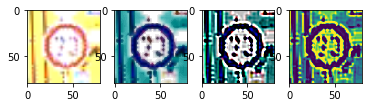

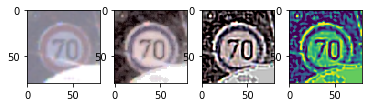

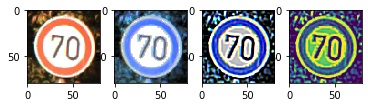

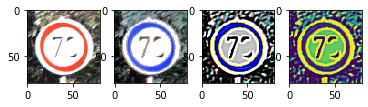

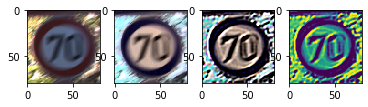

In [294]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00004/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00004/00000_00008.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00004/00002_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00004/00001_00001.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00004/00047_00026.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00004/00005_00029.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00004/00006_00029.ppm')

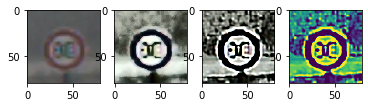

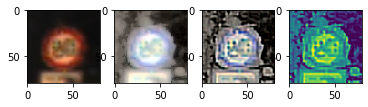

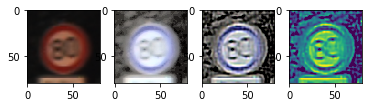

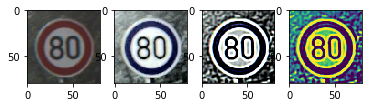

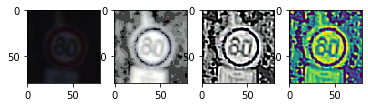

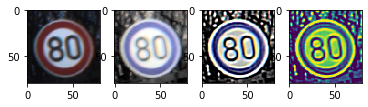

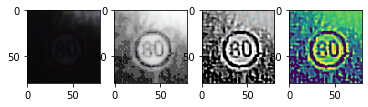

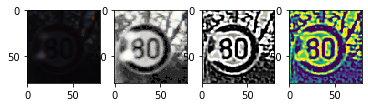

In [295]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00001_00028.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00000_00026.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00007_00010.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00047_00026.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00011_00006.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00005/00010_00026.ppm')

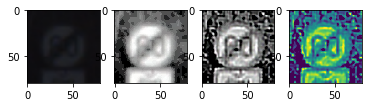

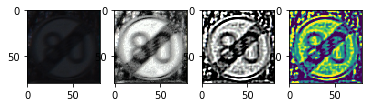

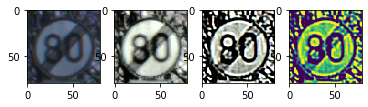

In [296]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00006/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00006/00000_00029.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00006/00003_00025.ppm')

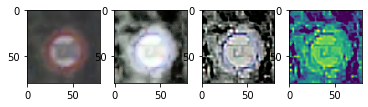

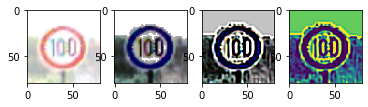

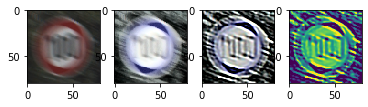

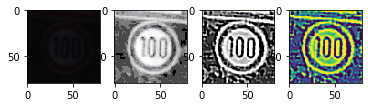

In [297]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00007/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00007/00002_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00007/00000_00028.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00007/00004_00017.ppm')

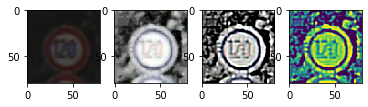

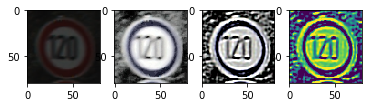

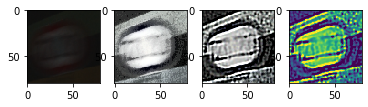

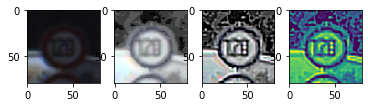

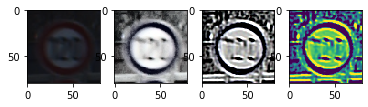

In [298]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00008/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00008/00000_00029.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00008/00002_00029.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00008/00005_00002.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00008/00007_00026.ppm')

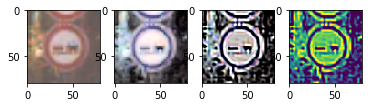

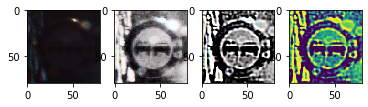

In [299]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00009/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00009/00047_00026.ppm')

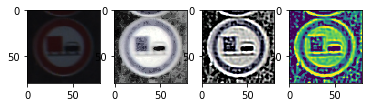

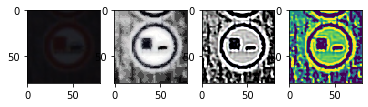

In [300]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00010/00007_00024.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00010/00008_00012.ppm')

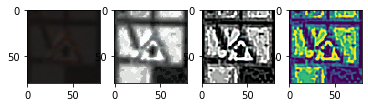

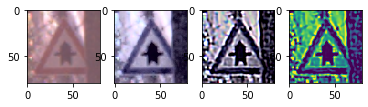

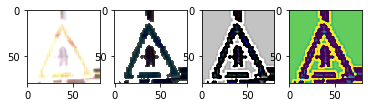

In [301]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00011/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00011/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00011/00002_00001.ppm')

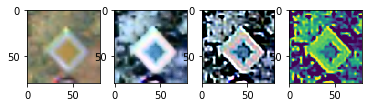

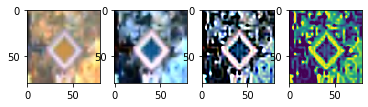

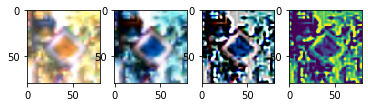

In [302]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00012/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00012/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00012/00002_00001.ppm')

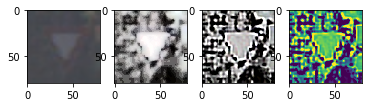

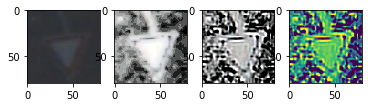

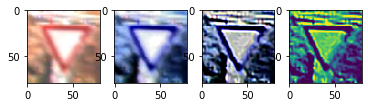

In [303]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00013/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00013/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00013/00002_00001.ppm')

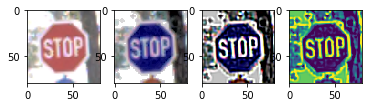

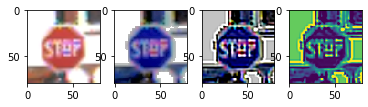

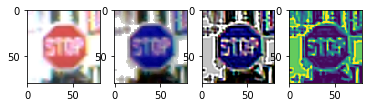

In [304]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00014/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00014/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00014/00002_00001.ppm')

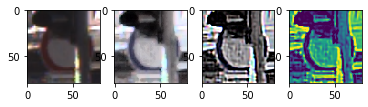

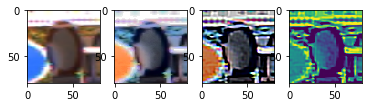

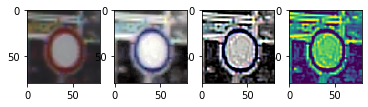

In [305]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00015/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00015/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00015/00002_00001.ppm')

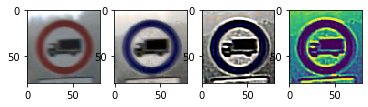

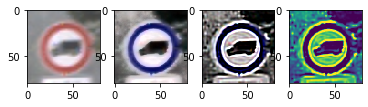

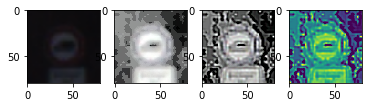

In [306]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00016/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00016/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00016/00002_00001.ppm')

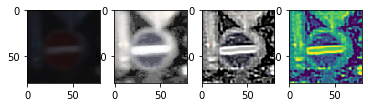

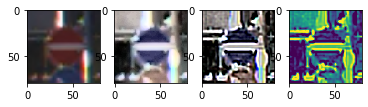

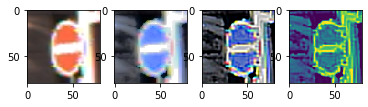

In [307]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00017/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00017/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00017/00002_00001.ppm')

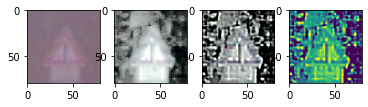

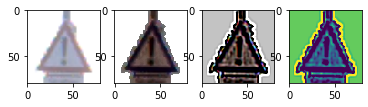

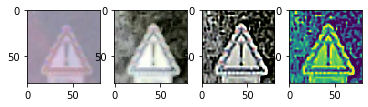

In [308]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00018/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00018/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00018/00002_00001.ppm')

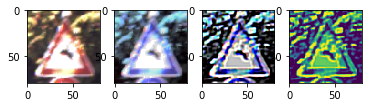

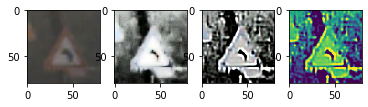

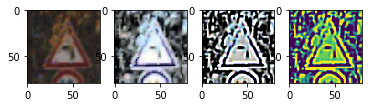

In [309]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00019/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00019/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00019/00002_00001.ppm')

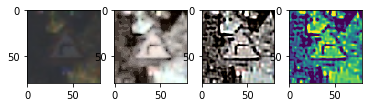

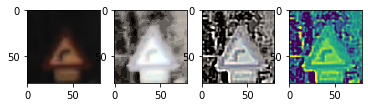

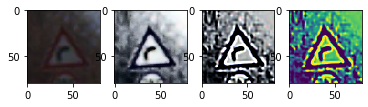

In [310]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00020/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00020/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00020/00002_00001.ppm')

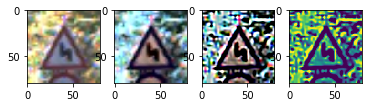

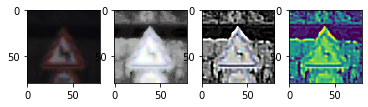

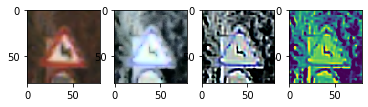

In [311]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00021/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00021/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00021/00002_00001.ppm')

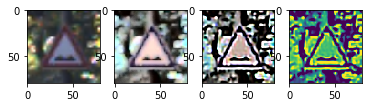

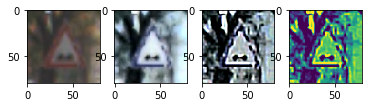

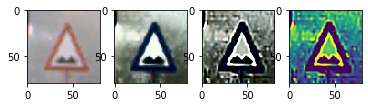

In [312]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00022/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00022/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00022/00002_00001.ppm')

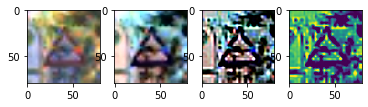

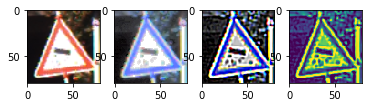

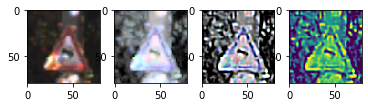

In [313]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00023/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00023/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00023/00002_00001.ppm')

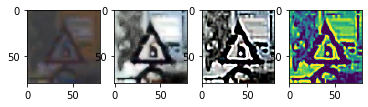

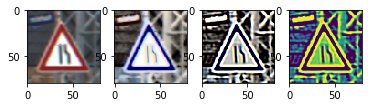

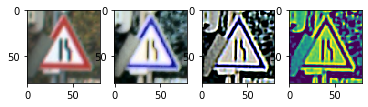

In [314]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00024/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00024/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00024/00002_00001.ppm')

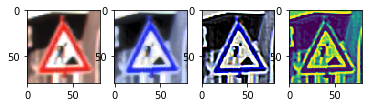

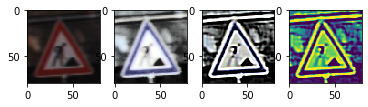

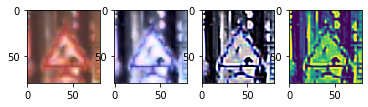

In [315]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00025/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00025/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00025/00002_00001.ppm')

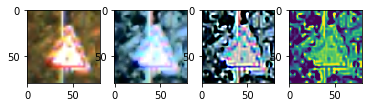

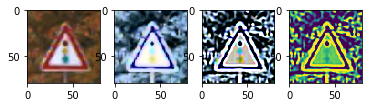

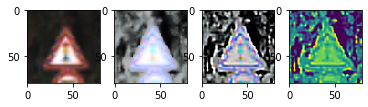

In [316]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00026/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00026/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00026/00002_00001.ppm')

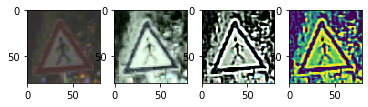

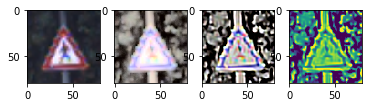

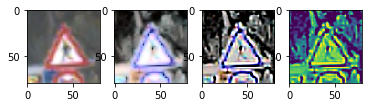

In [317]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00027/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00027/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00027/00002_00001.ppm')

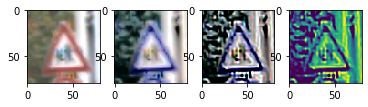

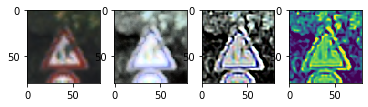

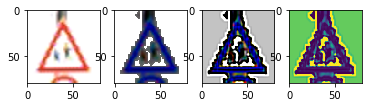

In [318]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00028/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00028/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00028/00002_00001.ppm')

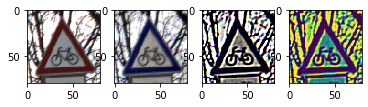

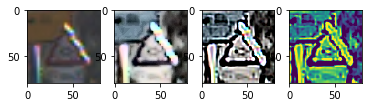

In [319]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00029/00004_00028.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00029/00006_00002.ppm')

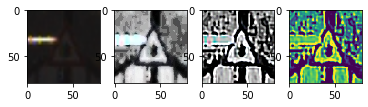

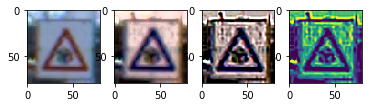

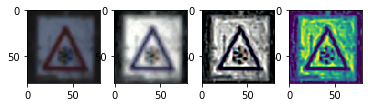

In [320]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00030/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00030/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00030/00002_00001.ppm')

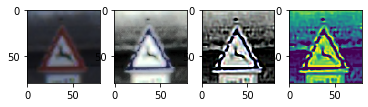

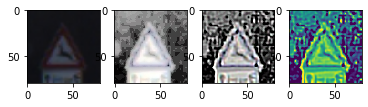

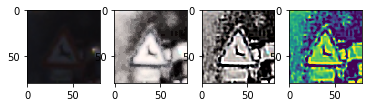

In [321]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00031/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00031/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00031/00002_00001.ppm')

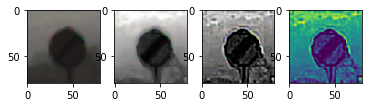

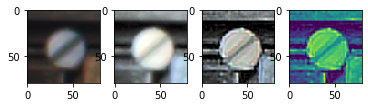

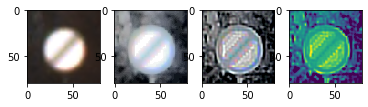

In [322]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00032/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00032/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00032/00002_00001.ppm')

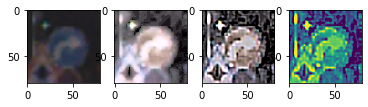

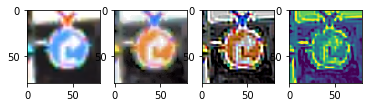

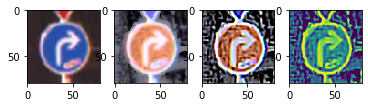

In [323]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00033/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00033/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00033/00002_00001.ppm')

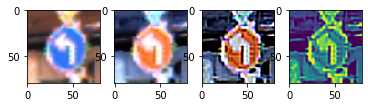

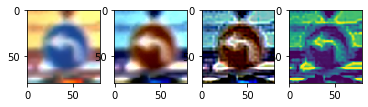

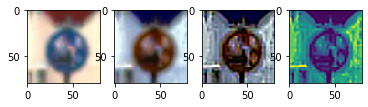

In [324]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00034/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00034/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00034/00002_00001.ppm')

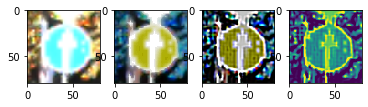

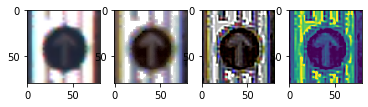

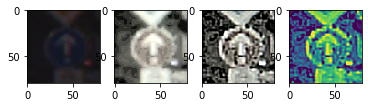

In [325]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00035/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00035/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00035/00002_00001.ppm')

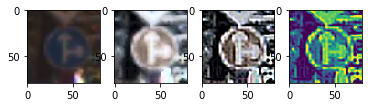

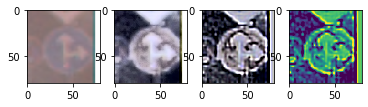

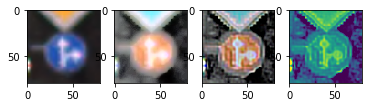

In [326]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00036/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00036/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00036/00002_00001.ppm')

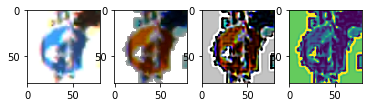

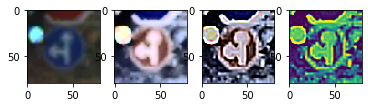

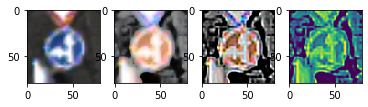

In [327]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00037/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00037/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00037/00002_00001.ppm')

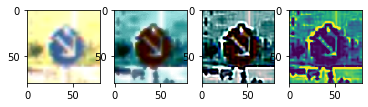

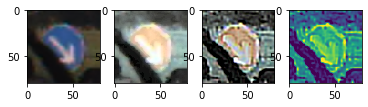

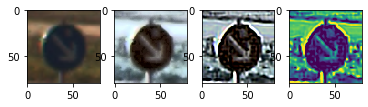

In [328]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00038/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00038/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00038/00002_00001.ppm')

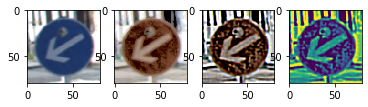

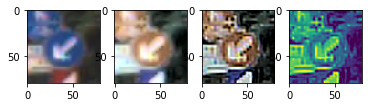

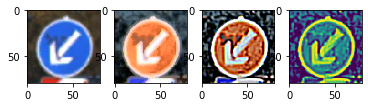

In [329]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00039/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00039/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00039/00002_00001.ppm')

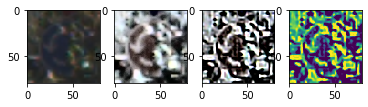

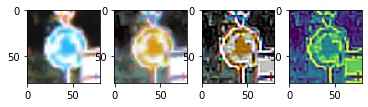

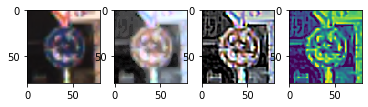

In [330]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00040/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00040/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00040/00002_00001.ppm')

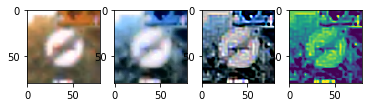

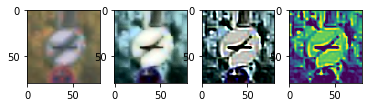

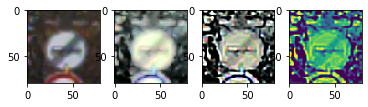

In [331]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00041/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00041/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00041/00002_00001.ppm')

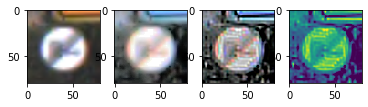

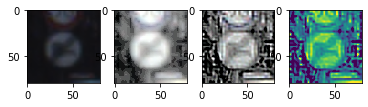

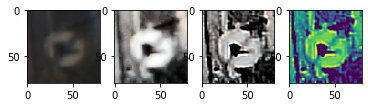

In [332]:
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00042/00000_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00042/00001_00000.ppm')
# ProposedSegmentationAlgoWithDisplay('../DataSet/Training_DataSet/Final_Training/Images/00042/00002_00001.ppm')